In [1]:
import os
import numpy as np
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import models, layers
from datetime import datetime
import soundfile as sf
import sounddevice as sd

def add_noise(data, noise_level=0.02):
    """Ajoute du bruit gaussien pour augmenter les données."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def augment_data(audio, sr=16000):
    """Augmente les données audio."""
    noisy_audio = add_noise(audio)
    shifted_audio = np.roll(audio, shift=int(0.1 * sr))  # Décalage temporel
    stretched_audio = librosa.effects.time_stretch(audio, rate=1.1)  # Étirement temporel
    return [audio, noisy_audio, shifted_audio, stretched_audio]

def detect_active_regions(audio, sr=16000, window_size=1600, hop_size=800, threshold=0.01):
    """Détecte les régions actives dans un signal audio en utilisant une fenêtre glissante."""
    active_regions = []
    for start in range(0, len(audio) - window_size + 1, hop_size):
        window = audio[start:start + window_size]
        energy = np.sum(np.abs(window))
        if energy > threshold:
            active_regions.append((start, start + window_size))
    if len(active_regions) == 0:
        return None
    return active_regions

def preprocess_audio_with_regions(audio, sr=16000):
    """Prépare un signal audio en utilisant les régions actives détectées."""
    regions = detect_active_regions(audio, sr=sr)
    if not regions:
        return None  # Silence détecté
    
    processed_features = []
    for start, end in regions:
        trimmed_audio = audio[start:end]
        trimmed_audio = librosa.util.normalize(trimmed_audio)
        features = extract_features(trimmed_audio, sr=sr)
        features_resized = cv2.resize(features, (128, 128)) / 255.0
        processed_features.append(features_resized.reshape(1, 128, 128, 1))
    return np.mean(processed_features, axis=0)  # Moyenne des régions actives

def extract_features(audio, sr=16000):
    """Extrait plusieurs caractéristiques d'un signal audio."""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    features = np.vstack([mfccs, chroma, mel])
    return features

def save_spectrogram(spectrogram, folder, base_filename):
    """Sauvegarde un spectrogramme sous forme d'image PNG."""
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_{timestamp}.png"
    filepath = os.path.join(folder, filename)
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', cmap='viridis')
    plt.axis('off')
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Spectrogramme sauvegardé dans : {filepath}")

def load_and_augment_data(folder, label, sr=16000):
    """Charge les fichiers audio, applique des augmentations et génère des données augmentées."""
    dataset = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            audio, _ = librosa.load(file_path, sr=sr)
            augmented_audios = augment_data(audio, sr)
            for aug_audio in augmented_audios:
                features = extract_features(aug_audio, sr=sr)
                features_resized = cv2.resize(features, (128, 128))  # Redimensionnement
                dataset.append((features_resized, label))
    return dataset

def build_model(input_shape, num_classes):
    """Construit un modèle CNN pour la reconnaissance vocale."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def record_audio(sr=16000, duration=2):
    """Enregistre un court extrait audio via le microphone."""
    print("Parlez maintenant...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("Enregistrement terminé.")
    return audio.flatten()

def preprocess_audio(audio, sr=16000):
    """Prépare un signal audio pour la prédiction."""
    trimmed_audio = trim_silence(audio, sr=sr)
    if len(trimmed_audio) == 0:
        return None  # Retourner None si aucun signal actif
    
    trimmed_audio = librosa.util.normalize(trimmed_audio)
    features = extract_features(trimmed_audio, sr=sr)
    features_resized = cv2.resize(features, (128, 128))
    features_resized = features_resized / 255.0  # Normalisation
    return features_resized.reshape(1, 128, 128, 1)

def predict_audio(model, label_encoder, audio, sr=16000):
    """Prédit un mot à partir d'un signal audio donné."""
    if audio is None:
        return "Silence détecté", 0.0
    spectrogram_resized = preprocess_audio(audio, sr=sr)
    if spectrogram_resized is None:
        return "Silence détecté", 0.0
    
    prediction = model.predict(spectrogram_resized)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0, predicted_index]
    return label_encoder.inverse_transform([predicted_index])[0], confidence

def evaluate_model(model, X_test, y_test, label_encoder):
    """Évalue les performances du modèle avec des données de test."""
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.show()

def plot_training_curves(history):
    """Trace les courbes d'entraînement et de validation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, label='Précision entraînement')
    plt.plot(epochs, val_acc, label='Précision validation')
    plt.title('Précision')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Perte entraînement')
    plt.plot(epochs, val_loss, label='Perte validation')
    plt.title('Perte')
    plt.legend()
    plt.show()

def plot_roc(y_test, y_pred, num_classes):
    """Trace les courbes ROC pour chaque classe."""
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Classe {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend()
    plt.show()



In [29]:
# Charger les données
allumer_folder = r"C:/Users/flavi/projet/allumer"
eteindre_folder = r"C:/Users/flavi/projet/eteindre"
inconnu_folder = r"C:/Users/flavi/projet/inconnu"

# Chargement et préparation des données
data_folders = {"allumer": allumer_folder, "eteindre": eteindre_folder, "inconnu": inconnu_folder}
dataset = []
for label, folder in data_folders.items():
    dataset += load_and_augment_data(folder, label)



In [30]:
# Préparation des données pour le modèle
X, y = zip(*dataset)
X = np.array(X).reshape(-1, 128, 128, 1) / 255.0  # Normalisation
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [32]:
# Construction et entraînement du modèle
model = build_model(input_shape=(128, 128, 1), num_classes=len(data_folders))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [33]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
63/63 [==============================] - 3s 30ms/step - loss: 2.5518 - accuracy: 0.6598 - val_loss: 1.1577 - val_accuracy: 0.1944
Epoch 2/100
63/63 [==============================] - 1s 22ms/step - loss: 0.6049 - accuracy: 0.7898 - val_loss: 2.2748 - val_accuracy: 0.1643
Epoch 3/100
63/63 [==============================] - 1s 22ms/step - loss: 0.5600 - accuracy: 0.8018 - val_loss: 1.4355 - val_accuracy: 0.3687
Epoch 4/100
63/63 [==============================] - 1s 22ms/step - loss: 0.4732 - accuracy: 0.8369 - val_loss: 4.2610 - val_accuracy: 0.1683
Epoch 5/100
63/63 [==============================] - 1s 22ms/step - loss: 0.4408 - accuracy: 0.8585 - val_loss: 1.6348 - val_accuracy: 0.4349
Epoch 6/100
63/63 [==============================] - 1s 22ms/step - loss: 0.4156 - accuracy: 0.8450 - val_loss: 0.9348 - val_accuracy: 0.6854
Epoch 7/100
63/63 [==============================] - 1s 22ms/step - loss: 0.3973 - accuracy: 0.8630 - val_loss: 0.6714 - val_accuracy: 0.7595
Epoch 

20/20 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

     allumer       0.98      0.96      0.97       292
    eteindre       0.91      0.99      0.95       251
     inconnu       0.93      0.77      0.84        81

    accuracy                           0.95       624
   macro avg       0.94      0.90      0.92       624
weighted avg       0.95      0.95      0.94       624



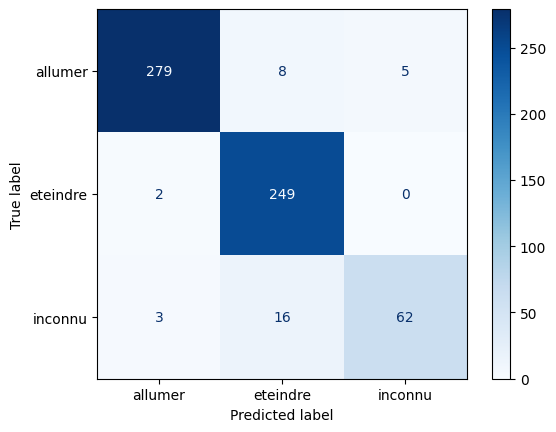

In [34]:
# Évaluation du modèle
evaluate_model(model, X_test, y_test, LabelEncoder().fit(list(data_folders.keys())))


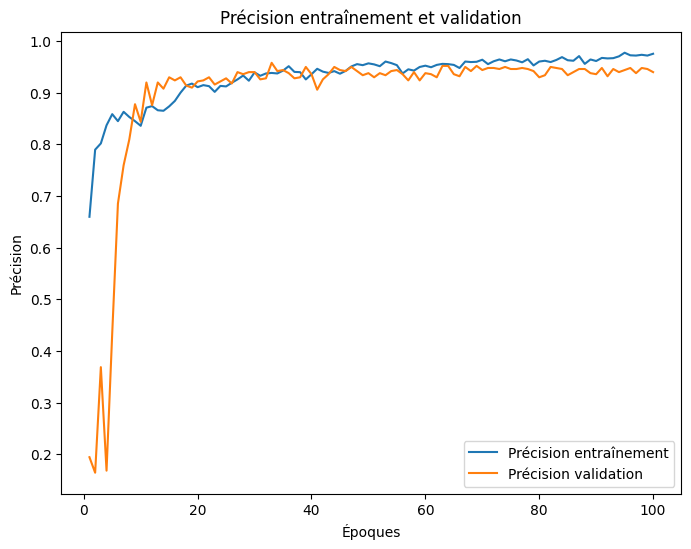

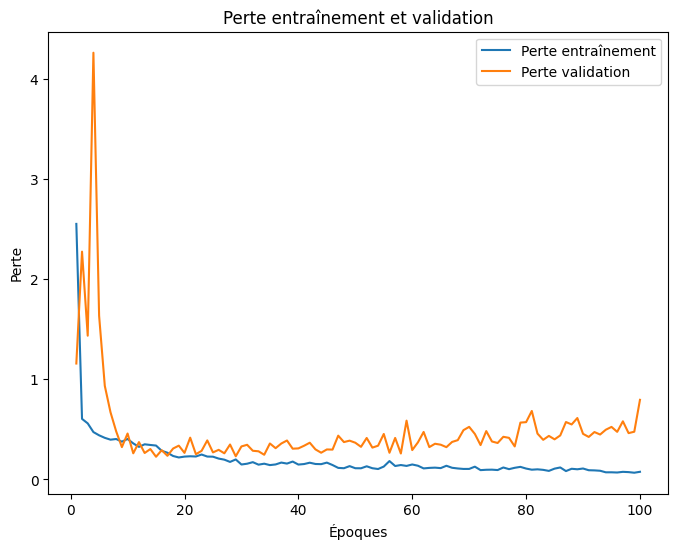

In [36]:
# Courbes de précision et de perte
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Précision
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, label='Précision entraînement')
    plt.plot(epochs, val_acc, label='Précision validation')
    plt.title('Précision entraînement et validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()

    # Perte
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Perte entraînement')
    plt.plot(epochs, val_loss, label='Perte validation')
    plt.title('Perte entraînement et validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

plot_training_curves(history)



In [50]:
# Tester la prédiction en temps réel
audio = record_audio()
predicted_label, confidence = predict_audio(model, LabelEncoder().fit(list(data_folders.keys())), audio)
print(f"Prédiction en temps réel : {predicted_label} (Confiance : {confidence:.2f})")

Parlez maintenant...
Enregistrement terminé.
1/1 [==============================] - 0s 29ms/step
Prédiction en temps réel : allumer (Confiance : 1.00)
